### Let's start with downloading the raw data

In [1]:
import sys
import os
# to reach the dataloader_functions module
module_path = os.path.abspath(os.path.join( ".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from dataloader_functions.download_data import download_raw_data
current_dir = os.getcwd()

In [16]:
### TODO update this section per dataset
dataset_config = {
    'dataset_name': 'stack_overflow',
    'source': 'kaggle',
    'remote_path': 'berkayalan/stack-overflow-annual-developer-survey-2024',
    'files': ['survey_results_public.csv'],
    'rename_files': ['stackoverflow_salary_data.csv'],
    'task': 'reg', # ['reg', 'cls']
    'target': 'Yearly_Salary_USD',
}

In [3]:
if dataset_config['task'] == 'clf':
    dataset_subfolder = os.path.join('raw', 'classification', dataset_config['dataset_name']) 
elif dataset_config['task'] == 'reg':
    dataset_subfolder = os.path.join('raw', 'regression', dataset_config['dataset_name'])
else:
    raise ValueError(f"Unknown task: {dataset_config['task']}")

# this path needs to be modified based on the location of the notebook
download_path = os.path.join(current_dir, '..', '..', 'datasets_files', dataset_subfolder)

if download_raw_data(
    dataset_config=dataset_config,
    download_path=download_path,
    force_download=False,
    remove_unlisted=True,
) is not None:
    print(f"Downloaded {dataset_config['dataset_name']} dataset to {download_path}")

Info: Dataset already downloaded in /media/martin/martin_work/TabAdap_Project/datasets_notebooks/regression/../../datasets_files/raw/regression/stackoverflow_salary.
Downloaded stackoverflow_salary dataset to /media/martin/martin_work/TabAdap_Project/datasets_notebooks/regression/../../datasets_files/raw/regression/stackoverflow_salary


In [4]:
import os
import pandas as pd

# Load dataset
raw_data_path = os.path.join(download_path, dataset_config['rename_files'][0])
raw_data = pd.read_csv(raw_data_path)

# Filter rows where salary is not NaN and within a reasonable range
filtered_data = raw_data[
    raw_data['ConvertedCompYearly'].notna() &
    (raw_data['ConvertedCompYearly'] > 1000)
]

# Overwrite the original CSV with the filtered data
filtered_data.to_csv(raw_data_path, index=False)

### Now we need to preprocess the data

In [5]:
from dataloader_functions.load_and_pp_raw_data import _drop_empty_columns, _drop_single_value_columns
from dataloader_functions.utils.data_2_df import read_any_to_df
import pandas as pd

import os
current_dir = os.getcwd()

In [6]:

dataset_files_df = []

if dataset_config['rename_files'] is None or len(dataset_config['rename_files']) == 0:
    dataset_config['rename_files'] = dataset_config['files']

for file in dataset_config['rename_files']:

    file_location = os.path.join(download_path, file)

    print(f"Loading {file_location}")

    dataset_files_df.append(read_any_to_df(file_location))

# example of the loaded df data:
pd.set_option('display.max_columns', None)
dataset_files_df[0].head(n=3)

Loading /media/martin/martin_work/TabAdap_Project/datasets_notebooks/regression/../../datasets_files/raw/regression/stackoverflow_salary/stackoverflow_salary_data.csv


,ResponseId,MainBranch,Age,Employment,RemoteWork,Check,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,TechDoc,YearsCode,YearsCodePro,DevType,OrgSize,PurchaseInfluence,BuyNewTool,BuildvsBuy,TechEndorse,Country,Currency,CompTotal,LanguageHaveWorkedWith,LanguageWantToWorkWith,LanguageAdmired,DatabaseHaveWorkedWith,DatabaseWantToWorkWith,DatabaseAdmired,PlatformHaveWorkedWith,PlatformWantToWorkWith,PlatformAdmired,WebframeHaveWorkedWith,WebframeWantToWorkWith,WebframeAdmired,EmbeddedHaveWorkedWith,EmbeddedWantToWorkWith,EmbeddedAdmired,MiscTechHaveWorkedWith,MiscTechWantToWorkWith,MiscTechAdmired,ToolsTechHaveWorkedWith,ToolsTechWantToWorkWith,ToolsTechAdmired,NEWCollabToolsHaveWorkedWith,NEWCollabToolsWantToWorkWith,NEWCollabToolsAdmired,OpSysPersonal use,OpSysProfessional use,OfficeStackAsyncHaveWorkedWith,OfficeStackAsyncWantToWorkWith,OfficeStackAsyncAdmired,OfficeStackSyncHaveWorkedWith,OfficeStackSyncWantToWorkWith,OfficeStackSyncAdmired,AISearchDevHaveWorkedWith,AISearchDevWantToWorkWith,AISearchDevAdmired,NEWSOSites,SOVisitFreq,SOAccount,SOPartFreq,SOHow,SOComm,AISelect,AISent,AIBen,AIAcc,AIComplex,AIToolCurrently Using,AIToolInterested in Using,AIToolNot interested in Using,AINextMuch more integrated,AINextNo change,AINextMore integrated,AINextLess integrated,AINextMuch less integrated,AIThreat,AIEthics,AIChallenges,TBranch,ICorPM,WorkExp,Knowledge_1,Knowledge_2,Knowledge_3,Knowledge_4,Knowledge_5,Knowledge_6,Knowledge_7,Knowledge_8,Knowledge_9,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,Frustration,ProfessionalTech,ProfessionalCloud,ProfessionalQuestion,Industry,JobSatPoints_1,JobSatPoints_4,JobSatPoints_5,JobSatPoints_6,JobSatPoints_7,JobSatPoints_8,JobSatPoints_9,JobSatPoints_10,JobSatPoints_11,SurveyLength,SurveyEase,ConvertedCompYearly,JobSat
0,73,I am a developer by profession,18-24 years old,"Employed, full-time;Student, full-time;Indepen...","Hybrid (some remote, some in-person)",Apples,Hobby;School or academic work;Professional dev...,"Secondary school (e.g. American high school, G...",On the job training;Other online resources (e....,Technical documentation;Blogs;Written Tutorial...,API document(s) and/or SDK document(s);User gu...,3,1,Data scientist or machine learning specialist,100 to 499 employees,I have some influence,Start a free trial;Ask developers I know/work ...,Is ready-to-go but also customizable for growt...,APIs;Customization;Integrated developer commun...,Pakistan,PKR\tPakistani rupee,2040000.0,Assembly;Bash/Shell (all shells);C;C++;HTML/CS...,C#;Rust;Scala,NaN,MongoDB;MySQL;SQLite,BigQuery;Cassandra;Databricks SQL;Elasticsearc...,NaN,Microsoft Azure;VMware,Amazon Web Services (AWS);Databricks;Google Cloud,NaN,Angular;AngularJS;Express;FastAPI;Flask;jQuery...,Django,NaN,CMake,NaN,NaN,Apache Kafka;Apache Spark;CUDA;Hadoop;Hugging ...,CUDA;mlflow;TensorFlow;Torch/PyTorch,CUDA;TensorFlow;Torch/PyTorch,Docker;Homebrew;Pip,Docker,Docker,IntelliJ IDEA;IPython;Jupyter Notebook/Jupyter...,NaN,NaN,MacOS;Windows,NaN,GitHub Discussions;Markdown File,NaN,NaN,Discord;Google Meet;Slack;Whatsapp;Zoom,NaN,NaN,ChatGPT;GitHub Copilot;Google Gemini;Visual St...,Meta AI,NaN,Stack Overflow;Stack Exchange,A few times per week,Yes,Less than once per month or monthly,Quickly finding code solutions;Finding reliabl...,"Yes, somewhat",Yes,Very favorable,Increase productivity;Greater efficiency;Impro...,Somewhat trust,"Good, but not great at handling complex tasks",Learning about a codebase;Writing code;Documen...,Project planning;Testing code;Committing and r...,NaN,Learning about a codebase;Writing code;Documen...,NaN,NaN,NaN,NaN,No,Circulating misinformation or disinformation;M...,"AI tools lack context of codebase, internal a...",Yes,People manager,3.0,Strongly agree,Strongly disagree,Strongly agree,Strongly agree,Strongly agree,Strongly agree,Strongly agree,Strongly agree,Strongly agree,1-2 times a week,6-10 times a week,Never,30-60 minutes a day,60-120 minutes a day,Amount of technical debt;Numb

In [7]:
## Run some basic data cleaning

dataset_files_gen_cleaned = []
missing_ratio_threshold = 0.5 # TODO the threshold can be changed

for df_file in dataset_files_df:
    df_size = df_file.shape
    # 1. Drop columns with more than 50% missing values
    df_file = _drop_empty_columns(df_file, threshold=missing_ratio_threshold)   
    # 2. Drop columns with only one unique value
    df_file = _drop_single_value_columns(df_file)
    # 3. remove duplicates
    df_file = df_file.drop_duplicates()
    # 4. remove rows with missing target values
    df_file = df_file[df_file['ConvertedCompYearly'].notna()]
    # 5. drop unnamed columns
    df_file = df_file.loc[:, ~df_file.columns.str.contains('^Unnamed')]

    dataset_files_gen_cleaned.append(df_file)

    print(f"Dataframe shape before/afrer cleaning: {df_size} / {df_file.shape}")

Dropped: Index(['EmbeddedHaveWorkedWith', 'EmbeddedWantToWorkWith', 'EmbeddedAdmired',
       'AIToolNot interested in Using', 'AINextMuch more integrated',
       'AINextNo change', 'AINextMore integrated', 'AINextLess integrated',
       'AINextMuch less integrated'],
      dtype='object')
Dataframe shape before/afrer cleaning: (22888, 114) / (22888, 104)


In [8]:
## TODO: Now run custom data cleaning -> remove non-essential columns

cols_to_drop = ['ResponseId']

dataset_files_cleaned = []

# assuming for multiple files we still want to drop the same columns
for df_file in dataset_files_gen_cleaned:
    df_size = df_file.shape
    for col in cols_to_drop:
        if col in df_file.columns:
            df_file.drop(col, axis=1, inplace=True)
        else:
            print(f"Column {col} not found in dataframe")

    dataset_files_cleaned.append(df_file)    
    print(f"Dataframe shape before/afrer by-hand cleaning: {df_size} / {df_file.shape}")


Dataframe shape before/afrer by-hand cleaning: (22888, 104) / (22888, 103)


In [9]:
# TODO: some custom data cleaning

import copy 
tmp_df = copy.deepcopy(dataset_files_cleaned)
dataset_files_by_hand_cleaned = []

for df_file in dataset_files_cleaned:
    print(f"Dataframe shape before custom cleaning: {df_file.shape}")
    # TODO: add custom data cleaning here
    # e.g. remove columns with too many unique values
    print(f"Dataframe shape after custom clearning: {df_file.shape}")

    dataset_files_by_hand_cleaned.append(df_file)

# reset the dataframe list to the version before custom cleaning -> next cells work wuth dataset_files_by_hand_cleaned
dataset_files_cleaned = tmp_df

Dataframe shape before custom cleaning: (22888, 103)
Dataframe shape after custom clearning: (22888, 103)


In [10]:
# as special case for this dataset, we need to convert the salry to the currency selected by the user
import numpy as np

# 1. print the unique values of the currency column
# Ensure all unique values are shown
pd.set_option('display.max_rows', None)

# Now display unique values without truncation
unique_currencies = sorted(dataset_files_cleaned[0]['Currency'].dropna().unique())
print(unique_currencies)


currency_to_usd = {
    'AED': 0.2723,   # United Arab Emirates dirham
    'AFN': 0.0154,   # Afghan afghani
    'ALL': 0.0105,   # Albanian lek
    'AMD': 0.0025,   # Armenian dram
    'AOA': 0.0012,   # Angolan kwanza
    'ARS': 0.0012,   # Argentine peso
    'AUD': 0.6810,   # Australian dollar
    'AZN': 0.5882,   # Azerbaijan manat
    'BAM': 0.5530,   # Bosnia and Herzegovina convertible mark
    'BDT': 0.0085,   # Bangladeshi taka
    'BGN': 0.5530,   # Bulgarian lev
    'BHD': 2.6596,   # Bahraini dinar
    'BIF': 0.00035,  # Burundi franc
    'BND': 0.7520,   # Brunei dollar
    'BOB': 0.1450,   # Bolivian boliviano
    'BRL': 0.2040,   # Brazilian real
    'BSD': 1.0000,   # Bahamian dollar
    'BTN': 0.0120,   # Bhutanese ngultrum
    'BWP': 0.0740,   # Botswana pula
    'BYN': 0.3930,   # Belarusian ruble
    'CAD': 0.7410,   # Canadian dollar
    'CHF': 1.1370,   # Swiss franc
    'CLP': 0.0012,   # Chilean peso
    'CNY': 0.1400,   # Chinese Yuan Renminbi
    'COP': 0.00025,  # Colombian peso
    'CRC': 0.0019,   # Costa Rican colon
    'CUP': 0.0417,   # Cuban peso
    'CVE': 0.0100,   # Cape Verdean escudo
    'CZK': 0.0430,   # Czech koruna
    'DKK': 0.1450,   # Danish krone
    'DOP': 0.0170,   # Dominican peso
    'DZD': 0.0074,   # Algerian dinar
    'EGP': 0.0320,   # Egyptian pound
    'ETB': 0.0175,   # Ethiopian birr
    'EUR': 1.0850,   # European Euro
    'FJD': 0.4510,   # Fijian dollar
    'FKP': 1.2700,   # Falkland Islands pound
    'GBP': 1.2700,   # Pound sterling
    'GEL': 0.3750,   # Georgian lari
    'GGP': 1.2700,   # Guernsey Pound
    'GHS': 0.0830,   # Ghanaian cedi
    'GTQ': 0.1280,   # Guatemalan quetzal
    'HKD': 0.1280,   # Hong Kong dollar
    'HNL': 0.0410,   # Honduran lempira
    'HUF': 0.0028,   # Hungarian forint
    'IDR': 0.000064, # Indonesian rupiah
    'ILS': 0.2850,   # Israeli new shekel
    'IMP': 1.2700,   # Manx pound
    'INR': 0.0120,   # Indian rupee
    'IQD': 0.00076,  # Iraqi dinar
    'IRR': 0.000024, # Iranian rial
    'ISK': 0.0073,   # Icelandic krona
    'JMD': 0.0065,   # Jamaican dollar
    'JOD': 1.4100,   # Jordanian dinar
    'JPY': 0.0066,   # Japanese yen
    'KES': 0.0063,   # Kenyan shilling
    'KGS': 0.0113,   # Kyrgyzstani som
    'KHR': 0.00024,  # Cambodian riel
    'KRW': 0.00077,  # South Korean won
    'KWD': 3.2500,   # Kuwaiti dinar
    'KZT': 0.0022,   # Kazakhstani tenge
    'LKR': 0.0031,   # Sri Lankan rupee
    'LYD': 0.2060,   # Libyan dinar
    'MAD': 0.0990,   # Moroccan dirham
    'MDL': 0.0560,   # Moldovan leu
    'MGA': 0.00022,  # Malagasy ariary
    'MKD': 0.0170,   # Macedonian denar
    'MMK': 0.00048,  # Myanmar kyat
    'MNT': 0.00029,  # Mongolian tugrik
    'MOP': 0.1240,   # Macanese pataca
    'MRU': 0.0250,   # Mauritanian ouguiya
    'MUR': 0.0220,   # Mauritian rupee
    'MVR': 0.0650,   # Maldivian rufiyaa
    'MWK': 0.00061,  # Malawian kwacha
    'MXN': 0.0580,   # Mexican peso
    'MYR': 0.2150,   # Malaysian ringgit
    'MZN': 0.0156,   # Mozambican metical
    'NAD': 0.0530,   # Namibian dollar
    'NGN': 0.0013,   # Nigerian naira
    'NIO': 0.0270,   # Nicaraguan cordoba
    'NOK': 0.0950,   # Norwegian krone
    'NPR': 0.0075,   # Nepalese rupee
    'NZD': 0.6210,   # New Zealand dollar
    'OMR': 2.6000,   # Omani rial
    'PEN': 0.2640,   # Peruvian sol
    'PHP': 0.0180,   # Philippine peso
    'PKR': 0.0036,   # Pakistani rupee
    'PLN': 0.2410,   # Polish zloty
    'PYG': 0.00014,  # Paraguayan guarani
    'QAR': 0.2747,   # Qatari riyal
    'RON': 0.2180,   # Romanian leu
    'RSD': 0.0091,   # Serbian dinar
    'RUB': 0.0108,   # Russian ruble
    'RWF': 0.00083,  # Rwandan franc
    'SAR': 0.2666,   # Saudi Arabian riyal
    'SEK': 0.0960,   # Swedish krona
    'SGD': 0.7520,   # Singapore dollar
    'SYP': 0.00040,  # Syrian pound
    'THB': 0.0280,   # Thai baht
    'TJS': 0.0910,   # Tajikistani somoni
    'TMT': 0.2850,   # Turkmen manat
    'TND': 0.3200,   # Tunisian dinar
    'TRY': 0.0340,   # Turkish lira
    'TTD': 0.1470,   # Trinidad and Tobago dollar
    'TWD': 0.0320,   # New Taiwan dollar
    'TZS': 0.00040,  # Tanzanian shilling
    'UAH': 0.0270,   # Ukrainian hryvnia
    'UGX': 0.00027,  # Ugandan shilling
    'USD': 1.0000,   # United States dollar
    'UYU': 0.0250,   # Uruguayan peso
    'UZS': 0.000082, # Uzbekistani som
    'VES': 0.000029, # Venezuelan bolivar
    'VND': 0.000041, # Vietnamese dong
    'WST': 0.3650,   # Samoan tala
    'XAF': 0.0017,   # Central African CFA franc
    'XDR': 1.3400,   # SDR (Special Drawing Right)
    'XOF': 0.0017,   # West African CFA franc
    'XPF': 0.0091,   # CFP franc
    'YER': 0.0040,   # Yemeni rial
    'ZAR': 0.0530,   # South African rand
    'ZMW': 0.0520    # Zambian kwacha
}

# Assuming:
# - Your DataFrame is called df_file (or dataset_files_cleaned[0])
# - Salary column is named 'Salary'
# - Currency column is named 'Currency'
# - You already have the `currency_to_usd` dictionary defined

def extract_currency_code(value):
    """Extracts the currency code (e.g., 'USD') from values like 'USD United States dollar'."""
    if pd.isna(value):
        return None
    return str(value).split()[0].strip()

# Add a column for currency codes (e.g., 'USD', 'EUR', etc.)
df_file['Currency_Code'] = df_file['Currency'].apply(extract_currency_code)

# Convert salary to USD for each row
def convert_row_salary(row):
    currency_code = row['Currency_Code']
    salary = row['ConvertedCompYearly']
    if pd.isna(salary) or pd.isna(currency_code):
        return np.nan
    rate = currency_to_usd.get(currency_code)
    if rate is None:
        print(f"⚠️ Missing rate for {currency_code}")
        return np.nan
    return salary * rate

# Create new column for salary in USD
df_file['Yearly_Salary_USD'] = df_file.apply(convert_row_salary, axis=1)


# now drop all unreasonable values
# Define sensible salary boundaries in USD
MIN_SALARY_USD = 1000
MAX_SALARY_USD = 1_000_000

size_before = df_file.shape

# Filter out unreasonable salaries
df_file = df_file[
    (df_file['Yearly_Salary_USD'] >= MIN_SALARY_USD) &
    (df_file['Yearly_Salary_USD'] <= MAX_SALARY_USD)
].copy()

print(f"Dataframe shape before/after filtering: {size_before} / {df_file.shape}")

# Final inspection
display(df_file[['Currency', 'Currency_Code', 'Yearly_Salary_USD']].head())

# drop the currency columns
dataset_files_by_hand_cleaned[0] = df_file.drop(columns=['Currency', 'Currency_Code'])


['AED United Arab Emirates dirham', 'AFN\tAfghan afghani', 'ALL\tAlbanian lek', 'AMD\tArmenian dram', 'AOA\tAngolan kwanza', 'ARS\tArgentine peso', 'AUD\tAustralian dollar', 'AZN\tAzerbaijan manat', 'BAM\tBosnia and Herzegovina convertible mark', 'BDT\tBangladeshi taka', 'BGN\tBulgarian lev', 'BHD\tBahraini dinar', 'BIF\tBurundi franc', 'BND\tBrunei dollar', 'BOB\tBolivian boliviano', 'BRL\tBrazilian real', 'BSD\tBahamian dollar', 'BTN\tBhutanese ngultrum', 'BWP\tBotswana pula', 'BYN\tBelarusian ruble', 'CAD\tCanadian dollar', 'CHF\tSwiss franc', 'CLP\tChilean peso', 'CNY\tChinese Yuan Renminbi', 'COP\tColombian peso', 'CRC\tCosta Rican colon', 'CUP\tCuban peso', 'CVE\tCape Verdean escudo', 'CZK\tCzech koruna', 'DKK\tDanish krone', 'DOP\tDominican peso', 'DZD\tAlgerian dinar', 'EGP\tEgyptian pound', 'ETB\tEthiopian birr', 'EUR European Euro', 'FJD\tFijian dollar', 'FKP\tFalkland Islands pound', 'GBP\tPound sterling', 'GEL\tGeorgian lari', 'GGP\tGuernsey Pound', 'GHS\tGhanaian cedi', 'G

,Currency,Currency_Code,Yearly_Salary_USD
1,EUR European Euro,EUR,32630.290
2,EUR European Euro,EUR,99055.075
3,EUR European Euro,EUR,58267.755
4,USD\tUnited States dollar,USD,110000.000
5,GBP\tPound sterling,GBP,204525.880


### Now it is time to visualize our changes

In [11]:
pd.set_option('display.max_columns', None)

dataset_files_by_hand_cleaned[0].head(n=3)

,MainBranch,Age,Employment,RemoteWork,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,TechDoc,YearsCode,YearsCodePro,DevType,OrgSize,PurchaseInfluence,BuyNewTool,BuildvsBuy,TechEndorse,Country,CompTotal,LanguageHaveWorkedWith,LanguageWantToWorkWith,LanguageAdmired,DatabaseHaveWorkedWith,DatabaseWantToWorkWith,DatabaseAdmired,PlatformHaveWorkedWith,PlatformWantToWorkWith,PlatformAdmired,WebframeHaveWorkedWith,WebframeWantToWorkWith,WebframeAdmired,MiscTechHaveWorkedWith,MiscTechWantToWorkWith,MiscTechAdmired,ToolsTechHaveWorkedWith,ToolsTechWantToWorkWith,ToolsTechAdmired,NEWCollabToolsHaveWorkedWith,NEWCollabToolsWantToWorkWith,NEWCollabToolsAdmired,OpSysPersonal use,OpSysProfessional use,OfficeStackAsyncHaveWorkedWith,OfficeStackAsyncWantToWorkWith,OfficeStackAsyncAdmired,OfficeStackSyncHaveWorkedWith,OfficeStackSyncWantToWorkWith,OfficeStackSyncAdmired,AISearchDevHaveWorkedWith,AISearchDevWantToWorkWith,AISearchDevAdmired,NEWSOSites,SOVisitFreq,SOAccount,SOPartFreq,SOHow,SOComm,AISelect,AISent,AIBen,AIAcc,AIComplex,AIToolCurrently Using,AIToolInterested in Using,AIThreat,AIEthics,AIChallenges,TBranch,ICorPM,WorkExp,Knowledge_1,Knowledge_2,Knowledge_3,Knowledge_4,Knowledge_5,Knowledge_6,Knowledge_7,Knowledge_8,Knowledge_9,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,Frustration,ProfessionalTech,ProfessionalCloud,ProfessionalQuestion,Industry,JobSatPoints_1,JobSatPoints_4,JobSatPoints_5,JobSatPoints_6,JobSatPoints_7,JobSatPoints_8,JobSatPoints_9,JobSatPoints_10,JobSatPoints_11,SurveyLength,SurveyEase,ConvertedCompYearly,JobSat,Yearly_Salary_USD
1,"I am not primarily a developer, but I write co...",25-34 years old,"Employed, full-time","Hybrid (some remote, some in-person)",Hobby;School or academic work;Professional dev...,"Professional degree (JD, MD, Ph.D, Ed.D, etc.)",Books / Physical media;Colleague;On the job tr...,Written Tutorials;Stack Overflow;Written-based...,NaN,12,6,Academic researcher,100 to 499 employees,I have little or no influence,Start a free trial;Ask developers I know/work ...,Is set up to be customized and needs to be eng...,NaN,Austria,28000.0,C;C++;Fortran;MATLAB;Python;SQL,C;C++;MATLAB;Python;SQL,C;C++;MATLAB;Python;SQL,PostgreSQL,PostgreSQL,PostgreSQL,NaN,NaN,NaN,NaN,NaN,NaN,NumPy;Pandas;Scikit-Learn;TensorFlow;Torch/PyT...,NumPy;Pandas;Scikit-Learn;TensorFlow;Torch/PyT...,NumPy;Pandas;Scikit-Learn;TensorFlow;Torch/PyT...,NaN,NaN,NaN,Android Studio;IPython,Android Studio;IPython,Android Studio;IPython,Other Linux-based;Windows,Ubuntu;Windows,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stack Overflow;Stack Exchange,Multiple times per day,Yes,Multiple times per day,Quickly finding code solutions;Finding reliabl...,"Yes, somewhat","No, and I don't plan to",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Appropriate in length,Neither easy nor difficult,30074.0,NaN,32630.290
2,I am a developer by profession,35-44 years old,"Employed, full-time",Remote,Hobby;Bootstrapping a business,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Books / Physical media;Other online resources ...,Technical documentation;Books;Social Media;Wri...,API document(s) and/or SDK document(s),15,6,Data scientist or machine learning specialist,20 to 99 employees,I have a great deal of influence,Ask developers I know/work with;Research compa...,Is ready-to-go but also customizable for growt...,APIs;Connected to an open source project,Turkey,85000.0,JavaScript;Julia;Python;SQL;TypeScript,Go;JavaScript;Python;Rust;SQL;TypeScript,JavaScript;Python;SQL;TypeScript,DuckDB;PostgreSQL;SQLite,Clickhouse;DuckDB;PostgreSQL;SQLite,DuckDB;PostgreSQL;SQLite,Amazon Web Services (AWS);Cloudflare;Digital O...,Amazon Web Services (AWS);Cloudflare;Google Cl...,Amazon Web Services (AWS);Cloudflare;Hetzner,Next.js;React;Vue.js,Svelte;Vue.js,Vue.js,JAX;NumPy;Pandas;Ruff;Scikit-Learn;Torch/PyTorch,JAX;NumPy;Pandas;Ruff;Scikit-Learn;Tor

Let's figure out which columns should be viewed as categorical / numerical / textual

we can start with a simple heuristic:
1. numerical is everything which
    - keeps most of its character length after non-numeral strip
    - has about the same number of unique values after the strip
    + for the purpose of keeping "semantic information", hand picked columns can be viewed also as non-numerical, that is not the default benchmark approach though

2. categorical is everthing non numerical, which can be then divided into N (where N << Num instances) unique categories

3. textual is everything else

In [12]:
import pandas as pd
import re

def is_mostly_numeric(series, length_threshold=0.5, unique_threshold=0.8):
    """Check if column is mostly numeric after stripping non-numeric chars."""
    stripped = series.astype(str).str.replace(r"[^\d\.\-]", "", regex=True)
    
    original_len = series.astype(str).str.len().replace(0, 1)  # avoid div by zero
    length_ratio = (stripped.str.len() / original_len).mean()

    unique_ratio = stripped.nunique(dropna=False) / max(series.nunique(dropna=False), 1)

    return length_ratio > length_threshold and unique_ratio > unique_threshold

def classify_columns(df, unique_ratio_threshold=None, explicit_nunique_threshold=None):
    """
    Classify dataframe columns into numerical, categorical, textual.
    - Binary categorical (2 unique values) is considered categorical.
    """
    n_rows = len(df)

    # Determine threshold for categorical vs textual
    if explicit_nunique_threshold is not None:
        nunique_threshold = explicit_nunique_threshold
    elif unique_ratio_threshold is not None:
        nunique_threshold = int(unique_ratio_threshold * n_rows)
    else:
        nunique_threshold = int(0.05 * n_rows)  # default 5%

    nunique_threshold = max(10, nunique_threshold)  # safeguard
    print(f"Threshold for categorical vs textual: {nunique_threshold}")

    numerical_cols = []
    categorical_cols = []
    textual_cols = []

    for col in df.columns:
        series = df[col]
        nunique = series.nunique(dropna=False)

        if pd.api.types.is_numeric_dtype(series):
            if nunique <= nunique_threshold:
                categorical_cols.append(col)
            else:
                numerical_cols.append(col)
        
        elif pd.api.types.is_string_dtype(series) or pd.api.types.is_object_dtype(series):
            if is_mostly_numeric(series):
                numerical_cols.append(col)
            else:
                if nunique <= nunique_threshold:
                    categorical_cols.append(col)
                else:
                    textual_cols.append(col)
        else:
            print(f"⚠️ Unhandled column type: '{col}' (dtype={series.dtype})")

    print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols}")
    print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")
    print(f"Textual columns ({len(textual_cols)}): {textual_cols}")

    return numerical_cols, categorical_cols, textual_cols

# Example usage:
for df_file in dataset_files_by_hand_cleaned:
    # Ratio-based (5% of rows)
    # umerical_cols, categorical_cols, textual_cols = classify_columns(df_file, unique_ratio_threshold=0.05)
    print("")
    # OR explicit value (e.g., anything <= 50 is categorical)
    numerical_cols, categorical_cols, textual_cols = classify_columns(df_file, explicit_nunique_threshold=50)



Threshold for categorical vs textual: 50
Numerical columns (15): ['YearsCode', 'YearsCodePro', 'CompTotal', 'WorkExp', 'JobSatPoints_1', 'JobSatPoints_4', 'JobSatPoints_5', 'JobSatPoints_6', 'JobSatPoints_7', 'JobSatPoints_8', 'JobSatPoints_9', 'JobSatPoints_10', 'JobSatPoints_11', 'ConvertedCompYearly', 'Yearly_Salary_USD']
Categorical columns (41): ['MainBranch', 'Age', 'Employment', 'RemoteWork', 'EdLevel', 'DevType', 'OrgSize', 'PurchaseInfluence', 'BuildvsBuy', 'NEWSOSites', 'SOVisitFreq', 'SOAccount', 'SOPartFreq', 'SOComm', 'AISelect', 'AISent', 'AIAcc', 'AIComplex', 'AIThreat', 'TBranch', 'ICorPM', 'Knowledge_1', 'Knowledge_2', 'Knowledge_3', 'Knowledge_4', 'Knowledge_5', 'Knowledge_6', 'Knowledge_7', 'Knowledge_8', 'Knowledge_9', 'Frequency_1', 'Frequency_2', 'Frequency_3', 'TimeSearching', 'TimeAnswering', 'ProfessionalCloud', 'ProfessionalQuestion', 'Industry', 'SurveyLength', 'SurveyEase', 'JobSat']
Textual columns (47): ['CodingActivities', 'LearnCode', 'LearnCodeOnline',

Now let's just try to visualize the kept features, their example values, and their cat/num/text allocation

In [13]:
summary = []
for col in df_file.columns:
    if col in categorical_cols:
        col_type = "categorical"
        num_categories = df_file[col].nunique(dropna=True)
        num_categories_display = int(num_categories)
    elif col in textual_cols:
        col_type = "textual"
        num_categories = df_file[col].nunique(dropna=True)
        num_categories_display = int(num_categories)
    elif col in numerical_cols:
        col_type = "numerical"
        num_categories = df_file[col].nunique(dropna=True)
        num_categories_display = '~ ' + str(num_categories) + ' ~'
    else:
        col_type = "unknown"
        num_categories_display = '--'

    example = df_file[col].dropna().iloc[0] if df_file[col].dropna().size > 0 else None
    summary.append({
        'Column Name': col,
        'Example Value': str(example),
        'Type': col_type,
        '# Categories': num_categories_display
    })

summary_df = pd.DataFrame(summary)

# TODO: by hand changes of the type and category count -> e.g. for 'Location':
#    # Post-processing: override the type and category count for 'Location'
#    # summary_df.loc[summary_df['Column Name'] == 'Location', 'Type'] = 'textual'
#    # num_categories = df_file['Location'].nunique(dropna=True)
#    # summary_df.loc[summary_df['Column Name'] == 'Location', '# Categories'] = int(num_categories)

pd.set_option('display.max_rows', None)
display(summary_df)  # Or print(summary_df)

,Column Name,Example Value,Type,# Categories
0,MainBranch,"I am not primarily a developer, but I write co...",categorical,2
1,Age,25-34 years old,categorical,8
2,Employment,"Employed, full-time",categorical,46
3,RemoteWork,"Hybrid (some remote, some in-person)",categorical,3
4,CodingActivities,Hobby;School or academic work;Professional dev...,textual,102
5,EdLevel,"Professional degree (JD, MD, Ph.D, Ed.D, etc.)",categorical,8
6,LearnCode,Books / Physical media;Colleague;On the job tr...,textual,345
7,LearnCodeOnline,Written Tutorials;Stack Overflow;Written-based...,textual,5347
8,TechDoc,API document(s) and/or SDK document(s),textual,93
9,YearsCode,12,numerical,~ 52 ~


### Saving the processed data and loading it back up

In [18]:
import os
import pandas as pd

# Handle rename_files fallback
if dataset_config['rename_files'] is None or len(dataset_config['rename_files']) == 0:
    dataset_config['rename_files'] = dataset_config['files']

for i, df_file in enumerate(dataset_files_by_hand_cleaned):
    df_with_meta = df_file.copy()

    # Get corresponding file name
    file_name = dataset_config['rename_files'][i]
    file_base = os.path.splitext(file_name)[0]

    # Try assigning multi-index header from summary
    try:
        df_with_meta.columns = pd.MultiIndex.from_frame(
            summary_df[['Column Name', 'Type', '# Categories']]
        )
        local_summary = summary_df.copy()
    except ValueError:
        local_summary = summary_df.copy()
        if dataset_config['target'] in local_summary['Column Name'].values:
            local_summary = local_summary[local_summary['Column Name'] != dataset_config['target']]
            df_with_meta.columns = pd.MultiIndex.from_frame(
                local_summary[['Column Name', 'Type', '# Categories']]
            )
        else:
            raise

    # Construct and save everything together
    output_filename = f"{dataset_config['dataset_name']}_processed.pkl"
    output_path = os.path.join(download_path, output_filename)

    if os.path.exists(output_path):
        print(f"File {output_path} already exists. Skipping save.")
        continue

    save_bundle = {
        'data': df_with_meta,
        'summary': local_summary,
        'config': dataset_config
    }

    pd.to_pickle(save_bundle, output_path)
    print(f"Saved: {output_path}")


Saved: /media/martin/martin_work/TabAdap_Project/datasets_notebooks/regression/../../datasets_files/raw/regression/stackoverflow_salary/stack_overflow_processed.pkl


In [19]:
import os
import pandas as pd

import sys
import os
# to reach the dataloader_functions module
module_path = os.path.abspath(os.path.join( "..", "..", ".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from configs.dataset_configs import get_a_dataset_dict

print(dataset_config['dataset_name'])

loaded_dataset_config = get_a_dataset_dict(dataset_config['dataset_name'])

file_base = loaded_dataset_config['name']
processed_filename = f"{file_base}_processed.pkl"
processed_path = os.path.join(download_path, processed_filename)

# Load the bundled dictionary (data + summary + config)
bundle = pd.read_pickle(processed_path)

# Extract components
loaded_df = bundle['data']
summary_df = bundle['summary']
loaded_config = bundle['config']

print(f"\n=== {file_base.upper()} ===")
print(f"Loaded config keys: {list(loaded_config.keys())}")

# Show metadata
meta_df = pd.DataFrame(loaded_df.columns.tolist(), columns=['Column Name', 'Type', '# Categories'])
display(meta_df)

# Flatten for modeling
loaded_df.columns = loaded_df.columns.get_level_values(0)
display(loaded_df.head(n=3))


stack_overflow

=== STACK_OVERFLOW ===
Loaded config keys: ['dataset_name', 'source', 'remote_path', 'files', 'rename_files', 'task', 'target']


,Column Name,Type,# Categories
0,MainBranch,categorical,2
1,Age,categorical,8
2,Employment,categorical,46
3,RemoteWork,categorical,3
4,CodingActivities,textual,102
5,EdLevel,categorical,8
6,LearnCode,textual,345
7,LearnCodeOnline,textual,5347
8,TechDoc,textual,93
9,YearsCode,numerical,~ 52 ~


Column Name,MainBranch,Age,Employment,RemoteWork,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,TechDoc,YearsCode,YearsCodePro,DevType,OrgSize,PurchaseInfluence,BuyNewTool,BuildvsBuy,TechEndorse,Country,CompTotal,LanguageHaveWorkedWith,LanguageWantToWorkWith,LanguageAdmired,DatabaseHaveWorkedWith,DatabaseWantToWorkWith,DatabaseAdmired,PlatformHaveWorkedWith,PlatformWantToWorkWith,PlatformAdmired,WebframeHaveWorkedWith,WebframeWantToWorkWith,WebframeAdmired,MiscTechHaveWorkedWith,MiscTechWantToWorkWith,MiscTechAdmired,ToolsTechHaveWorkedWith,ToolsTechWantToWorkWith,ToolsTechAdmired,NEWCollabToolsHaveWorkedWith,NEWCollabToolsWantToWorkWith,NEWCollabToolsAdmired,OpSysPersonal use,OpSysProfessional use,OfficeStackAsyncHaveWorkedWith,OfficeStackAsyncWantToWorkWith,OfficeStackAsyncAdmired,OfficeStackSyncHaveWorkedWith,OfficeStackSyncWantToWorkWith,OfficeStackSyncAdmired,AISearchDevHaveWorkedWith,AISearchDevWantToWorkWith,AISearchDevAdmired,NEWSOSites,SOVisitFreq,SOAccount,SOPartFreq,SOHow,SOComm,AISelect,AISent,AIBen,AIAcc,AIComplex,AIToolCurrently Using,AIToolInterested in Using,AIThreat,AIEthics,AIChallenges,TBranch,ICorPM,WorkExp,Knowledge_1,Knowledge_2,Knowledge_3,Knowledge_4,Knowledge_5,Knowledge_6,Knowledge_7,Knowledge_8,Knowledge_9,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,Frustration,ProfessionalTech,ProfessionalCloud,ProfessionalQuestion,Industry,JobSatPoints_1,JobSatPoints_4,JobSatPoints_5,JobSatPoints_6,JobSatPoints_7,JobSatPoints_8,JobSatPoints_9,JobSatPoints_10,JobSatPoints_11,SurveyLength,SurveyEase,ConvertedCompYearly,JobSat,Yearly_Salary_USD
1,"I am not primarily a developer, but I write co...",25-34 years old,"Employed, full-time","Hybrid (some remote, some in-person)",Hobby;School or academic work;Professional dev...,"Professional degree (JD, MD, Ph.D, Ed.D, etc.)",Books / Physical media;Colleague;On the job tr...,Written Tutorials;Stack Overflow;Written-based...,NaN,12,6,Academic researcher,100 to 499 employees,I have little or no influence,Start a free trial;Ask developers I know/work ...,Is set up to be customized and needs to be eng...,NaN,Austria,28000.0,C;C++;Fortran;MATLAB;Python;SQL,C;C++;MATLAB;Python;SQL,C;C++;MATLAB;Python;SQL,PostgreSQL,PostgreSQL,PostgreSQL,NaN,NaN,NaN,NaN,NaN,NaN,NumPy;Pandas;Scikit-Learn;TensorFlow;Torch/PyT...,NumPy;Pandas;Scikit-Learn;TensorFlow;Torch/PyT...,NumPy;Pandas;Scikit-Learn;TensorFlow;Torch/PyT...,NaN,NaN,NaN,Android Studio;IPython,Android Studio;IPython,Android Studio;IPython,Other Linux-based;Windows,Ubuntu;Windows,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stack Overflow;Stack Exchange,Multiple times per day,Yes,Multiple times per day,Quickly finding code solutions;Finding reliabl...,"Yes, somewhat","No, and I don't plan to",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Appropriate in length,Neither easy nor difficult,30074.0,NaN,32630.290
2,I am a developer by profession,35-44 years old,"Employed, full-time",Remote,Hobby;Bootstrapping a business,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Books / Physical media;Other online resources ...,Technical documentation;Books;Social Media;Wri...,API document(s) and/or SDK document(s),15,6,Data scientist or machine learning specialist,20 to 99 employees,I have a great deal of influence,Ask developers I know/work with;Research compa...,Is ready-to-go but also customizable for growt...,APIs;Connected to an open source project,Turkey,85000.0,JavaScript;Julia;Python;SQL;TypeScript,Go;JavaScript;Python;Rust;SQL;TypeScript,JavaScript;Python;SQL;TypeScript,DuckDB;PostgreSQL;SQLite,Clickhouse;DuckDB;PostgreSQL;SQLite,DuckDB;PostgreSQL;SQLite,Amazon Web Services (AWS);Cloudflare;Digital O...,Amazon Web Services (AWS);Cloudflare;Google Cl...,Amazon Web Services (AWS);Cloudflare;Hetzner,Next.js;React;Vue.js,Svelte;Vue.js,Vue.js,JAX;NumPy;Pandas;Ruff;Scikit-Learn;Torch/PyTorch,JAX;NumPy;Pandas;Ruff;Sciki

### Bonus insights (Regression)

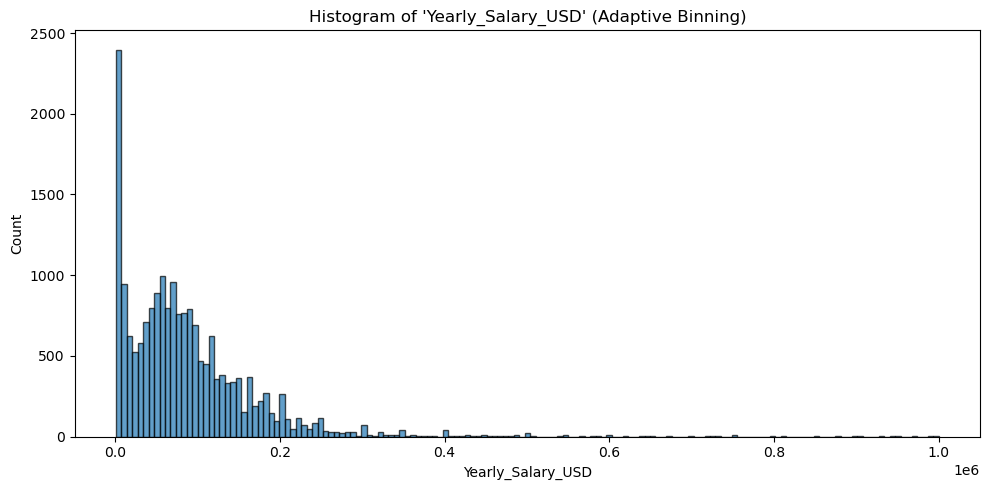

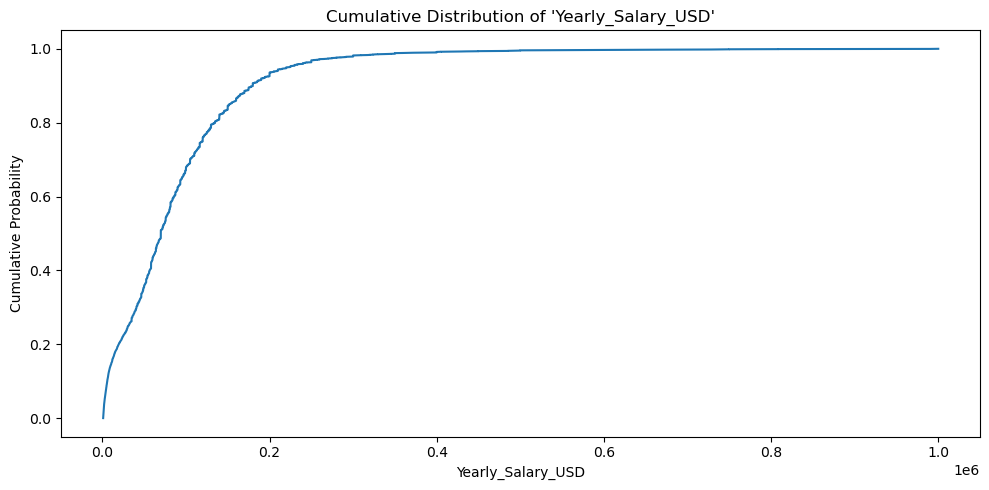

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get target series
target_series = loaded_df[dataset_config['target']]

# 1️⃣ Histogram with Freedman-Diaconis rule for binning
q25, q75 = np.percentile(target_series, [25, 75])
iqr = q75 - q25
bin_width = 2 * iqr * len(target_series) ** (-1/3)
bin_count = int((target_series.max() - target_series.min()) / bin_width)
bin_count = max(10, bin_count)  # Ensure reasonable minimum bin count

plt.figure(figsize=(10, 5))
plt.hist(target_series, bins=bin_count, edgecolor='black', alpha=0.7)
plt.title(f"Histogram of '{dataset_config['target']}' (Adaptive Binning)")
plt.xlabel(dataset_config['target'])
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 2️⃣ Cumulative Distribution Function (CDF)
target_sorted = target_series.sort_values()
cdf = np.arange(len(target_sorted)) / len(target_sorted)

plt.figure(figsize=(10, 5))
plt.plot(target_sorted, cdf, color='tab:blue')
plt.title(f"Cumulative Distribution of '{dataset_config['target']}'")
plt.xlabel(dataset_config['target'])
plt.ylabel('Cumulative Probability')
plt.tight_layout()
plt.show()

